# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: /10pts

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions, providing the python code in the cell below.

In [2]:
df = pd.read_csv('footballer_data.csv')

# Drop the columns

df = df.drop(labels=['ID', 'club', 'club_logo', 'birth_date', 'flag','nationality','photo','potential'], axis=1)

# Hint: In order to get dummies, you can first convert the column with strings to Categorical type using pandas,
# using a specific set of categories

columns = ['preferred_foot', 'work_rate_att', 'work_rate_def']
df[columns] = df[columns].astype('category')

model_data = pd.get_dummies(df, columns=columns, drop_first=True, dtype=int)
model_data.head()


,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,preferred_foot_Right,work_rate_att_Low,work_rate_att_Medium,work_rate_def_Low,work_rate_def_Medium
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,1,0,0,1,0
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,0,0,1,0,1
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,1,0,0,0,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,1,0,0,0,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,1,0,1,0,1


### Question 2: /10 pts

The data should all be numerical now. To evalute different models, define a function that returns the mean absolute error. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors on the original data that result if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the losses (absolute errors) and print their mean and standard deviation.

Mean of test loss (absolute errors): 5.491330443481161
Standard deviation of test loss: 4.261886186448831


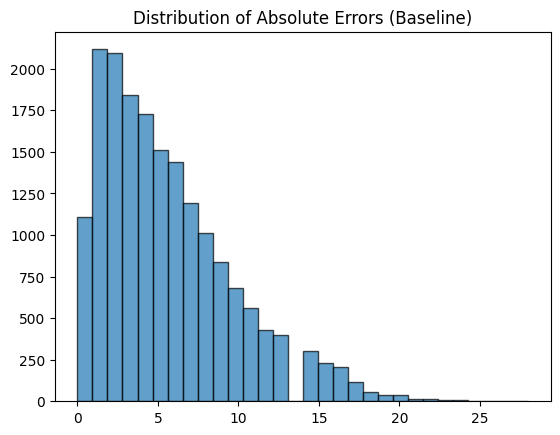

In [3]:
# Define mean absolute error function  
def meanAbsErr(act, pred):
    return np.mean(np.abs(act-pred))

median = np.median(model_data['overall'])
pred = np.full(len(model_data['overall']), median)

# Get mean and std of test loss 

abs_errors = np.abs(model_data['overall'] - pred)
mean_loss = meanAbsErr(model_data['overall'], pred)
std_loss = np.std(abs_errors)

print(f"Mean of test loss (absolute errors): {mean_loss}")
print(f"Standard deviation of test loss: {std_loss}")

# Plot distribution  
plt.hist(abs_errors, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Absolute Errors (Baseline)')
plt.show()




### Question 2: /15pts
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like you to choose the test set size so that the estimate of the performance of the final selected model is known to within $\pm 0.25$ units at a 95% confidence interval, using mean absolute error as the loss function of choice.

Recall that a CLT-based $95\%$ confidence interval for a mean is given by:

$ \bar{x} \pm \frac{1.96 \sigma_l}{\sqrt{n}}$,

If we equate the right hand side to $d$ and re-arrange, we can choose the test set size using the following formula, which gives the test size ($n_\mathrm{test}$) needed for a confidence interval to have width ($\pm d$) if the standard deviation of the loss is $\sigma_l$:

$ n_\textrm{test} = \left(\frac{1.96 \sigma_l}{d}\right)^2$.

Decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [4]:
d=0.25
nTest = int((((1.96*std_loss)/d)**2))

Xtrain, Xtest, Ytrain, Ytest = train_test_split(model_data.drop(columns=['overall']),df['overall'], test_size = nTest, random_state = 0)
print(f"Training set size: {Xtrain.shape[0]}", f"Test set size: {Xtest.shape[0]}")



Training set size: 16878 Test set size: 1116


### Question 4: /5pts
The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

In [5]:
linRegModel1 = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
    ])

linRegModel1.fit(Xtrain, Ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())])

### Question 5: /15pts

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model, using your mean absolute error function from question 2.  

In [6]:
cvs5fold = cross_val_score(linRegModel1, Xtrain, Ytrain, cv=5, scoring=make_scorer(meanAbsErr))
print("Cross Validation Score (5 folds): ", cvs5fold)

Cross Validation Score (5 folds):  [1.91474912 1.93085126 1.89361254 1.89463744 1.89616781]


### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. 

In [7]:
class Age2(BaseEstimator,TransformerMixin):  
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = X.assign(age2 = X['age']**2)
        return X

linRegModel2 = Pipeline([
    ('age2', Age2()),('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

print("Cross validation score, age: ", cross_val_score(linRegModel2, Xtrain, Ytrain, cv=5, scoring=make_scorer(meanAbsErr)))

Cross validation score, age:  [1.89473411 1.90506923 1.88104655 1.87009134 1.88637474]


### Question 7: /10 pts


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline.  Report the cross validation score.

In [ ]:
linRegModel3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

print("Cross validation score, Polynomial Features: ", cross_val_score(linRegModel3, Xtrain, Ytrain, cv=5, scoring=make_scorer(meanAbsErr)))

### Question 8: /10pts

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Explain why.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

I was told about your idea to explore third order interactions coming from our ML model. I want to let you know that this might have some unintended consequences. 

Firstly, adding cubic terms to the model may lead to potential **overfitting** (training error decreasing, but test error increasing), which would limit the ability of our model to generalize to unseen test data. This is due to the *bias-variance tradeoff* that would take place were the cubic terms added to the model we have created; bias would be low, but variance would be so high that our model would become useless due to high inaccuracy (test error).

Sincerly,

Junior Data Scientist



### Question 9:  /10pts

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

**a)** Based on the cross validation scores, which model would you choose?  

Coding:

Train your model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error. (A "point estimate" is a single number that we expect to be close to the thing we are trying to estimate.)
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

**b)** Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?


Point estimate for the generalization error (MAE/test error): 0.876
95% Confidence interval for the generalization error: (0.923, 0.829)


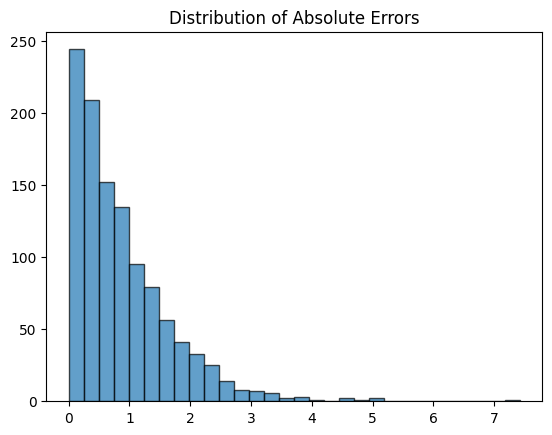

In [19]:
# Fit our best performing model on all the training data

newFit = linRegModel3.fit(Xtrain, Ytrain)

#Predict on the test set

predY = linRegModel3.predict(Xtest)

#Compute the errors and a point estimate of the generalization error

absErr = np.abs(Ytest-predY)

mae = meanAbsErr(Ytest, predY)

n = len(Ytest)
z = 1.96
moe = z * (np.std(absErr) / (n ** 0.5))

#Construct a confidence interval
# We have enough data in our test set that the appropirate t-quantile is close to 1.96 but you can use either 
# t- or z-distribution

CIup = mae - moe
CIlow = mae + moe

print(f"Point estimate for the generalization error (MAE/test error): {mae:.3f}")
print(f"95% Confidence interval for the generalization error: ({CIlow:.3f}, {CIup:.3f})")

plt.hist(absErr, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Absolute Errors')
plt.show()



**Answer a)** I would choose the polynomial features model as it has the lowest cross-validation score.

**Answer b)** Yes. I think this is the case because the model I picked performed the best and therefore generalized well, leading to consistency in the errors graphed. The folds in the previous question were representative of the overall dataset, too, and the test set was drawn from a similar distribution (that being the same .csv file), so the test error aligns closely with the model linRegModel3.

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.